In [2]:
import pandas as pd
import numpy as np
import os
# use this for matplotlib fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")
train_df.head()
print(test_df)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
5     1466          60       RL         75.0    10000   Pave   NaN      IR1   
6     1467          20       RL          NaN     7980   Pave   NaN      IR1   
7     1468          60       RL         63.0     8402   Pave   NaN      IR1   
8     1469          20       RL         85.0    10176   Pave   NaN      Reg   
9     1470          20       RL         70.0     8400   Pave   NaN      Reg   
10    1471         120       RH         26.0     5858   Pave   NaN      IR1   
11    1472         160       RM         21.0     168

In [3]:
# lets look at the sell prices
print(train_df["SalePrice"].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [4]:
# lets take a look at what features have strong correlation with each other
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# correlation matrix
# corrmat = train_df.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# f.set_facecolor("W")
# sns.heatmap(corrmat, vmax=.8, square=True);

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold

# lets do some modeling
train_df.dropna(axis = 0, subset = ["SalePrice"], inplace = True) # drop all with no sale price
y_train = train_df["SalePrice"].values
train_df = train_df.drop(["SalePrice"], axis = 1) # drop sale price column to avoid leakage

train_df.fillna(train_df.mean(), inplace = True)
test_df.fillna(test_df.mean(), inplace = True)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


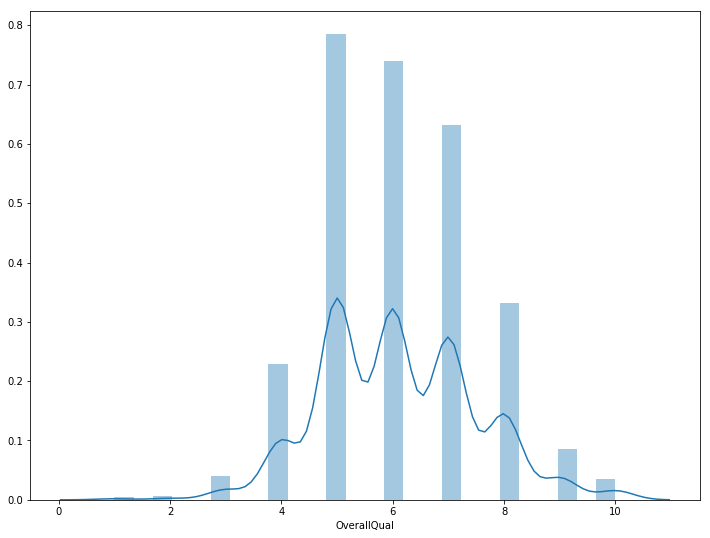

In [6]:
# do some feature engineering
# overall quality is very important
f, ax = plt.subplots(figsize=(12, 9))
f.set_facecolor("W")
sns.distplot(train_df["OverallQual"])

In [7]:
def get_quality_grade(quality):
    if isinstance(quality, float):
        return "N"
    elif quality <= 4:
        return "F"
    elif quality <= 5:
        return "D"
    elif quality <= 6:
        return "C"
    elif quality <= 7:
        return "B"
    elif quality <= 8:
        return "A"
    else:
        return "A+"

train_df["QualityGrade"] = train_df["OverallQual"].map(get_quality_grade)
test_df["QualityGrade"] = test_df["OverallQual"].map(get_quality_grade)

train_df = train_df.drop(["OverallQual"], axis = 1)
test_df = test_df.drop(["OverallQual"], axis = 1) 

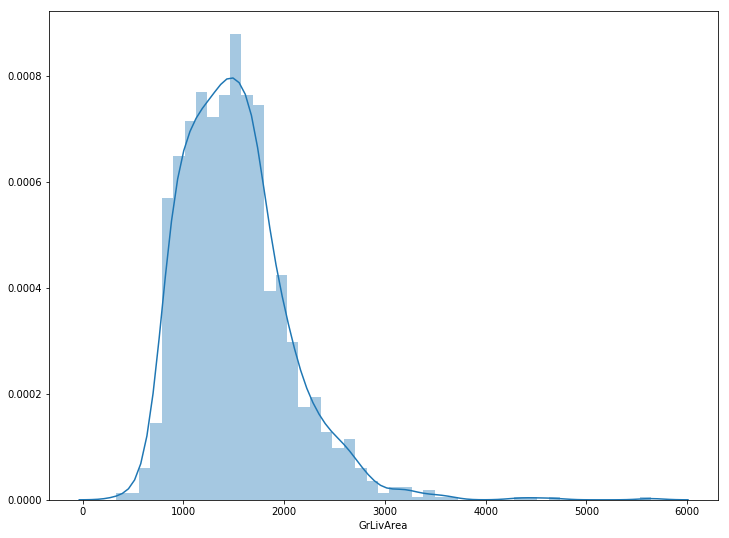

In [8]:
f, ax = plt.subplots(figsize=(12, 9))
f.set_facecolor("W")
sns.distplot(train_df["GrLivArea"])

def get_live_area(area):
    if area <= 500:
        return "VerySmall"
    elif area <= 1000:
        return "Small"
    elif area <= 1500:
        return "Med"
    elif area <= 2000:
        return "Decent"
    elif area <= 2500:
        return "Great"
    else:
        return "Large"

train_df["GrLivAreaGrade"] = train_df["GrLivArea"].map(get_live_area)
test_df["GrLivAreaGrade"] = test_df["GrLivArea"].map(get_live_area)

#train_df = train_df.drop(["GrLivArea"], axis = 1)
#test_df = test_df.drop(["GrLivArea"], axis = 1) 

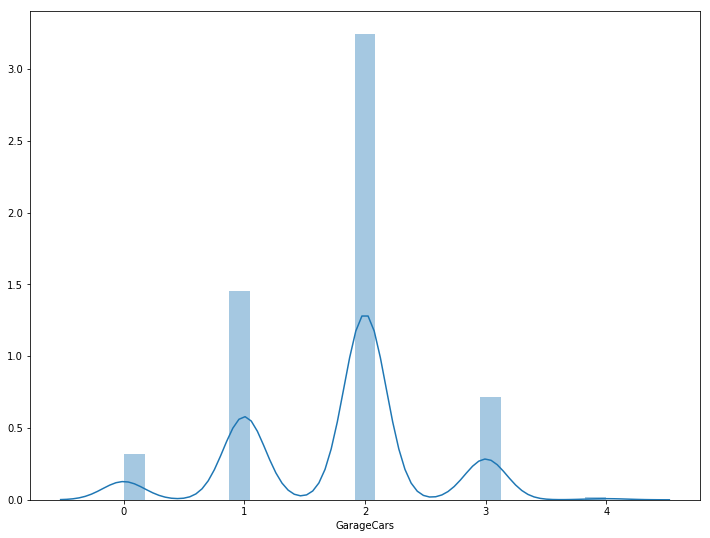

In [9]:
# garage cars feature
f, ax = plt.subplots(figsize=(12, 9))
f.set_facecolor("W")
sns.distplot(train_df["GarageCars"])

def get_garage_grade(cars):
    if cars == 0:
        return "D"
    elif cars <= 1:
        return "C"
    elif cars <= 2:
        return "B"
    elif cars <= 3:
        return "A"
    else:
        return "A+"

# we also saw that garage cars and garage area were large correlators
train_df["GarageCarArea"] = train_df["GarageCars"] * train_df["GarageArea"]
test_df["GarageCarArea"] = test_df["GarageCars"] * test_df["GarageArea"]
    
train_df["GarageCarsGrade"] = train_df["GarageCars"].map(get_garage_grade)
test_df["GarageCarsGrade"] = test_df["GarageCars"].map(get_garage_grade)

train_df = train_df.drop(["GarageCars"], axis = 1)
test_df = test_df.drop(["GarageCars"], axis = 1) 
#train_df = train_df.drop(["GarageArea"], axis = 1)
#test_df = test_df.drop(["GarageArea"], axis = 1) 

In [10]:
# some numerical features can be changed to categorical features
train_df["MSSubClass"] = train_df["MSSubClass"].astype(str)
test_df["MSSubClass"] = test_df["MSSubClass"].astype(str)

train_df["OverallCond"] = train_df["OverallCond"].astype(str)
test_df["OverallCond"] = test_df["OverallCond"].astype(str)

train_df['YrSold'] = train_df['YrSold'].astype(str)
test_df['YrSold'] = test_df['YrSold'].astype(str)

train_df['MoSold'] = train_df['MoSold'].astype(str)
test_df['MoSold'] = test_df['MoSold'].astype(str)

test_df['KitchenAbvGr'] = test_df['KitchenAbvGr'].astype(str)
train_df['KitchenAbvGr'] = train_df['KitchenAbvGr'].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

def label_encoder(all_data):
    for c in cols:
        if not isinstance(c, str) or c == 'Id':
            continue
        lbl = LabelEncoder() 
        lbl.fit(list(all_data[c].values)) 
        all_data[c] = lbl.transform(list(all_data[c].values))
    return all_data

train_df = label_encoder(train_df)
test_df = label_encoder(test_df)
print(train_df.columns)

In [ ]:
# get our dummy variables
dummies = train_df.select_dtypes(include = ["object"])
dummies = test_df.select_dtypes(include = ["object"])
train_df = pd.get_dummies(train_df, columns = dummies)
test_df  = pd.get_dummies(test_df, columns = dummies)
print(train_df.columns)

# lets go and remove dummies that arent present in the test dataframe
for col in train_df.columns:
    if col not in test_df.columns:
        train_df = train_df.drop([col], axis = 1)
        print(col)

X_train = train_df
X_test  = test_df
print(str(len(X_train.columns))+" "+str(len(X_test.columns)))

# create a few models
def getmean(scores):
    sum = 0
    for score in scores:
        sum += score
    return sum/float(len(scores))

xgbr_pipeline = make_pipeline(Imputer(), XGBRegressor())
scores = cross_val_score(xgbr_pipeline, X_train, y_train, cv = 4)
print("XGBRegressor "+str(getmean(scores)))

gbr_pipeline = make_pipeline(Imputer(), GradientBoostingRegressor(n_estimators = 4096))
scores = cross_val_score(gbr_pipeline, X_train, y_train, cv = 4)
print("Gradient Boosting "+str(getmean(scores)))

gbr_pipeline.fit(X_train, y_train)
preds = gbr_pipeline.predict(X_test)

output = pd.DataFrame(
    data = {
        "Id":test_df["Id"].values, "SalePrice":preds
    }
) # no indexing
output.to_csv("sub.csv", index = False)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandSlope', 'OverallCond', 'YearBuilt',
       ...
       'GrLivAreaGrade_Great', 'GrLivAreaGrade_Large', 'GrLivAreaGrade_Med',
       'GrLivAreaGrade_Small', 'GrLivAreaGrade_VerySmall', 'GarageCarsGrade_A',
       'GarageCarsGrade_A+', 'GarageCarsGrade_B', 'GarageCarsGrade_C',
       'GarageCarsGrade_D'],
      dtype='object', length=240)
Utilities_NoSeWa
Condition2_RRAe
Condition2_RRAn
Condition2_RRNn
HouseStyle_2.5Fin
RoofMatl_ClyTile
RoofMatl_Membran
RoofMatl_Metal
RoofMatl_Roll
Exterior1st_ImStucc
Exterior1st_Stone
Exterior2nd_Other
Heating_Floor
Heating_OthW
Electrical_Mix
KitchenAbvGr_3
MiscFeature_TenC
223 223
XGBRegressor 0.8748416336678553
